![Alt text](./figures/logo.png)

source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

<img src="./figures/culmen_depth.png" alt="Bill dimensions of a penguin" width="500"/>

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!


<img src="./figures/lter_penguins.png" alt="Illustration of the three penguin species" width="600"/>

In [1]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import seaborn as sns
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


## Reading the CSV File

The initial step involves reading the dataset from a CSV file. This forms the foundation for the subsequent data exploration and analysis. By loading the data into memory, it becomes accessible for inspection, transformation, and modelling in later stages of the project.


In [2]:
# Loading and examining the dataset
penguins_df = pd.read_csv("./data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


## Cleaning the Data

The uploaded dataset is examined to assess its overall quality and to prepare it for meaningful analysis. This stage includes the identification of missing values, the detection of outliers, and the verification of data types and consistency. Ensuring data cleanliness at this stage is crucial for producing reliable and accurate analytical results.


In [3]:
df = penguins_df  # Assign a shorter, more convenient variable name for easier handling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [5]:
df['sex'].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [6]:
df['sex']=df['sex'].astype('category')

In [7]:
df.describe(include='category')

,sex
count,332
unique,2
top,MALE
freq,167


In [8]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


### Observations

- A shorter alias, `'df'`, was created for the original DataFrame `'penguins_df'` to streamline code readability and reference.
- The dataset was checked for missing values, and none were found.
- The `'sex'` column comprises two distinct categories: `'MALE'` and `'FEMALE'`.
- This column was converted to the `'category'` data type to enhance memory efficiency and improve performance.
- No outliers were detected in the dataset, indicating a stable distribution of values across key variables.


## Preliminary Analysis

To initiate the exploratory analysis, a pair plot was generated to visualise the relationships among the numerical features within the dataset. This visual representation aids in identifying potential correlations, clusters, and patterns that may inform further analysis or model selection.


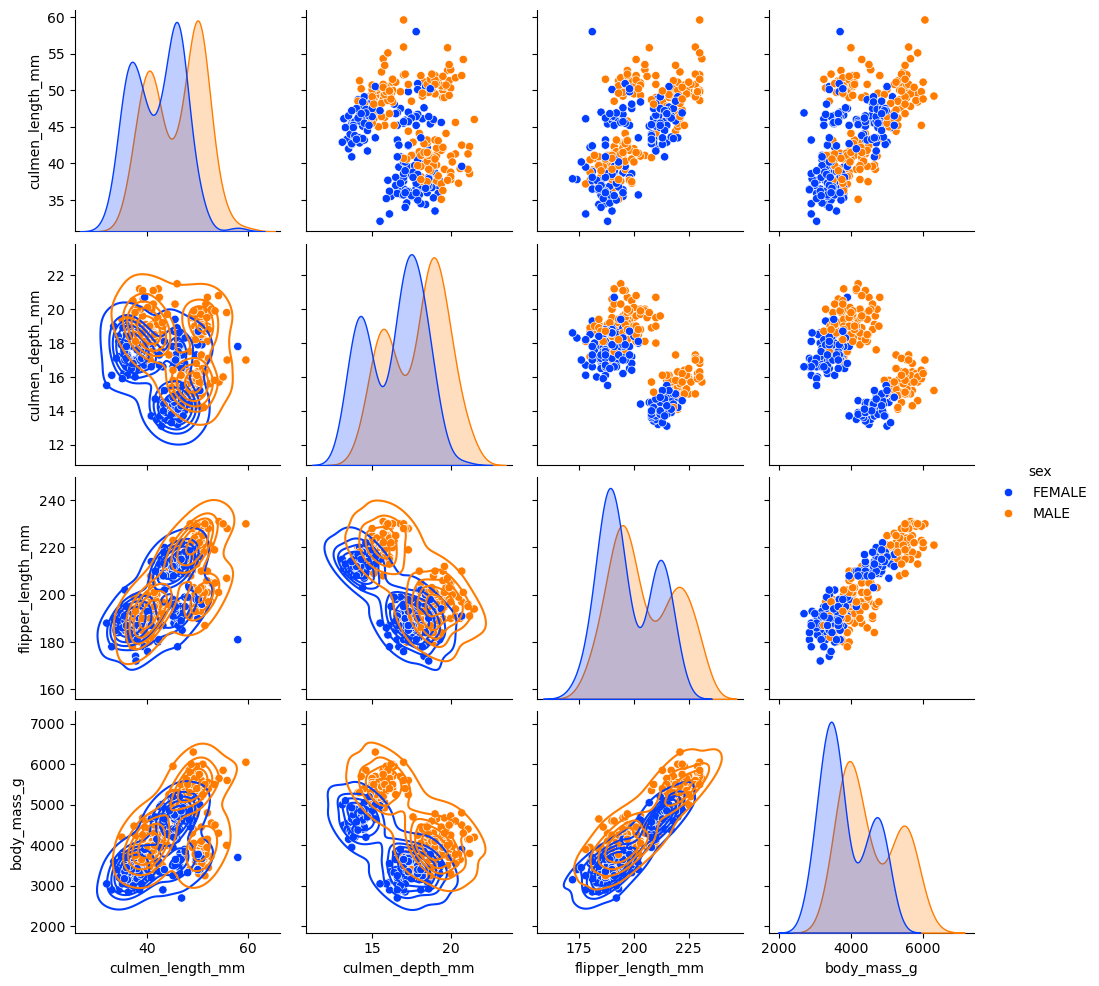

In [9]:
g = sns.pairplot(df, hue='sex', palette='bright')
g.map_lower(sns.kdeplot, levels=6, color="green")
plt.savefig('./plots/pairplot.png')
plt.show()

### Initial Insights

- The data has been categorised into two groups — `'MALE'` and `'FEMALE'` — and represented with distinct colours in the pair plot for clarity.
- Preliminary observations suggest that **male** individuals typically exhibit **larger body dimensions and higher body mass** compared to their female counterparts.
- Visual groupings apparent in the pair plot indicate the presence of three distinct clusters within the dataset, offering an encouraging indication of underlying species differentiation.
- The distributions of the four numerical features appear **bimodal**, which might initially suggest only two species. However, the emergence of three clear clusters reinforces the hypothesis of three distinct species being present.



## Clustering

### Dummy Variable Encoding

To prepare the dataset for clustering, the `'sex'` column is converted into a binary format using `pd.get_dummies`, retaining only one resulting column: `'sex_MALE'`. This column indicates the presence of the `'MALE'` category with a value of `1.0`; a value of `0.0` implies the individual is `'FEMALE'`.

By encoding the categorical variable in this manner and avoiding redundant columns, the dataset remains concise and fully numerical — a requirement for compatibility with clustering algorithms such as K-Means from the `scikit-learn` library.


In [10]:
df = pd.get_dummies(df,drop_first=True, dtype='float')
display(df.head())


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,39.1,18.7,181.0,3750.0,1.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
3,36.7,19.3,193.0,3450.0,0.0
4,39.3,20.6,190.0,3650.0,1.0


### Standardising the Dataset and Determining Optimal Clusters

Prior to applying clustering algorithms, the numerical features in the dataset are standardised using `StandardScaler` from the `scikit-learn` library. This transformation adjusts each feature to have a mean of 0 and a standard deviation of 1, ensuring uniformity in scale across all variables.

Standardisation is essential for clustering methods such as K-Means, which rely on distance-based calculations. Without this step, features with larger numerical ranges could disproportionately influence the clustering results.


In [11]:
scaler = StandardScaler()
samples = scaler.fit_transform(df)

### Elbow Analysis Procedure

The `KMeans` clustering algorithm is applied to the standardised dataset to evaluate various clustering configurations. A loop iterates over a range of cluster counts (`k` values from 1 to 10), fitting the algorithm to the data for each value of `k`.

Following each fit, the **inertia** — a metric that quantifies how closely the data points are grouped within clusters — is recorded. Lower inertia values suggest more cohesive clusters.

These inertia values are then plotted against their corresponding `k` values to produce an **elbow plot**. This visualisation aids in identifying the optimal number of clusters by highlighting the "elbow point" — the value of `k` at which additional clusters result in marginal gains in clustering performance.


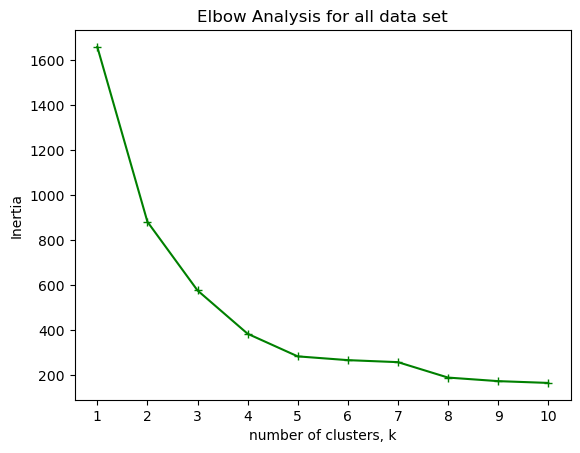

In [12]:
ks = range(1, 11)
inertias_all = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=69)
    kmeans.fit(samples)    # Fit model to samples    
    inertias_all.append(kmeans.inertia_) # Append the inertia to the list of inertias
    
# Plot ks vs inertias
plt.plot(ks, inertias_all, '-+', color='green')
plt.title('Elbow Analysis for all data set')
plt.xlabel('number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.savefig('./plots/elbow_test_all.png', format='png')
plt.show()

### Interpretation of Elbow Analysis

The elbow plot reveals a sharp decrease in inertia followed by a more gradual decline as `k` increases, with the curve beginning to level off around **`k = 5` or `k = 6`**. This indicates that beyond this point, additional clusters yield only marginal improvements in compactness.

This pattern suggests that **five or six clusters** may offer an appropriate segmentation of the dataset. These clusters could correspond to underlying substructures such as biological variation or latent groupings not explicitly captured by the existing features.

Notably, a smaller inflection point appears between **`k = 7` and `k = 8`**, hinting at the possibility of an additional, more subtle grouping. This may reflect greater complexity within the data than initially assumed — potentially even alluding to a **fourth species** or nuanced variation within the known categories.

Choosing an appropriate value for `k` based on this analysis supports the creation of meaningful, interpretable clusters, while maintaining a balance between model complexity and explanatory power.

## Clustering Analysis with **k = 5** Clusters

Following the results of the elbow analysis, `k = 5` has been selected as the number of clusters for further investigation. This choice reflects a compromise between model complexity and interpretability, aiming to uncover potential latent structures within the data without introducing excessive fragmentation.

At this stage, the `KMeans` algorithm is applied to the standardised dataset with `k = 5` clusters. Once the model is fitted, the resulting cluster labels are assigned to each observation and appended to the dataset to facilitate downstream analysis.

The outcomes of this clustering process now provide a foundation for visual exploration and interpretation of the distinct group characteristics identified within the data.



In [13]:
# Run KMeans with the optimal number of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters,  random_state=69)
kmeans.fit(samples)

labels = kmeans.labels_ # Get cluster labels and add it to the dataframe
df['label'] = labels
display(df.sample(10))

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,label
252,42.7,13.7,208.0,3950.0,0.0,3
188,45.5,17.0,196.0,3500.0,0.0,2
316,41.7,14.7,210.0,4700.0,0.0,3
157,47.0,17.3,185.0,3700.0,0.0,2
155,46.6,17.8,193.0,3800.0,0.0,2
118,40.6,19.0,199.0,4000.0,1.0,0
331,49.9,16.1,213.0,5400.0,1.0,1
110,37.3,20.5,199.0,3775.0,1.0,0
37,44.1,19.7,196.0,4400.0,1.0,0
253,49.6,16.0,225.0,5700.0,1.0,1


### Visualising Cluster Distributions by Feature

To better understand how the clustering algorithm has segmented the data, each numerical feature is plotted against the assigned cluster labels. A 2×2 grid of scatter plots is used to display the distributions of four key biological measurements: culmen length, culmen depth, flipper length, and body mass.

These visualisations help identify which features contribute most to the separation between clusters and reveal potential patterns or group characteristics. By colouring the points based on cluster labels, the plots offer a clearer view of how distinct or overlapping the clusters appear across each measurement.



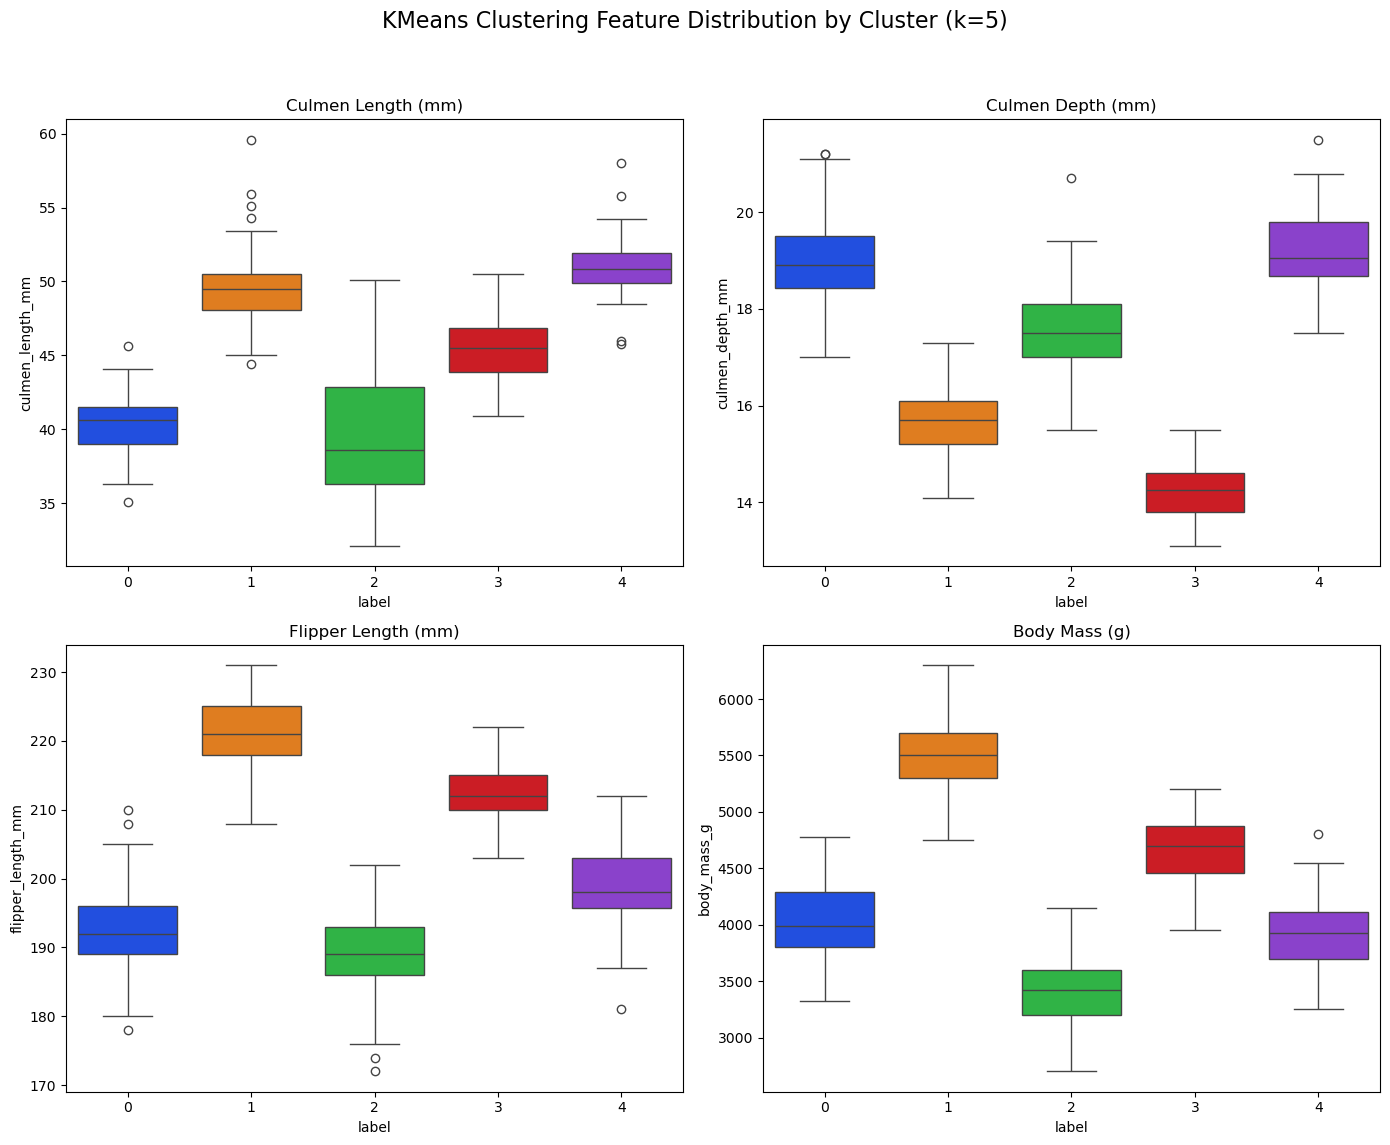

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle(f'KMeans Clustering Feature Distribution by Cluster (k={n_clusters})', fontsize=16)

# Plot 1: Culmen Length
sns.boxplot(ax=axs[0, 0], data=df, x='label', y='culmen_length_mm', hue='label', palette='bright')
axs[0, 0].set_title('Culmen Length (mm)')

# Plot 2: Culmen Depth
sns.boxplot(ax=axs[0, 1], data=df, x='label', y='culmen_depth_mm', hue='label', palette='bright')
axs[0, 1].set_title('Culmen Depth (mm)')

# Plot 3: Flipper Length
sns.boxplot(ax=axs[1, 0], data=df, x='label', y='flipper_length_mm', hue='label', palette='bright')
axs[1, 0].set_title('Flipper Length (mm)')

# Plot 4: Body Mass
sns.boxplot(ax=axs[1, 1], data=df, x='label', y='body_mass_g', hue='label', palette='bright')
axs[1, 1].set_title('Body Mass (g)')

# Clean up repeated legends
for ax in axs.flat:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/matrix_feat_labels_boxs.png', format='png')
plt.show()


### Investigating Cluster Composition by Sex

Following the examination of numerical features, the next step involves assessing the relationship between the identified clusters and the `'sex'` variable. Although this feature was not used as a primary driver in the clustering process, visualising its distribution across clusters can reveal whether any gender-based patterns emerged implicitly.

The plot below displays the binary-encoded `'sex_MALE'` variable against the assigned cluster labels. This comparison may uncover tendencies for certain clusters to be more associated with either male or female individuals, providing further insight into the characteristics captured by the clustering algorithm.


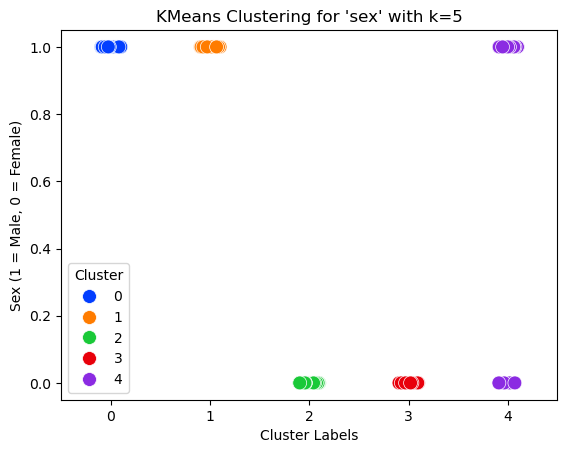

In [15]:
sns.stripplot(data=df, 
              x='label', 
              y='sex_MALE', 
              hue='label', 
              palette='bright', 
              jitter=True, 
              dodge=False, 
              edgecolor='w', 
              s=10, 
              linewidth=0.5)
plt.xlabel('Cluster Labels')
plt.ylabel('Sex (1 = Male, 0 = Female)')
plt.title(f"KMeans Clustering for 'sex' with k={n_clusters}")
plt.legend(title='Cluster')
plt.savefig('./plots/label_sex_k5_stripplot.png', format='png')
plt.show()

### t-SNE Map: Visualising Cluster Relationships

To further investigate the structure of the dataset before finalising the number of clusters, **t-distributed Stochastic Neighbour Embedding (t-SNE)** was applied to project the high-dimensional data into two dimensions. This technique preserves local relationships between samples, providing an intuitive visual representation of how data points group together in reduced space.

The resulting map reveals six visually distinct clusters, though two of these are **closely positioned**, with boundaries that nearly overlap. A small number of points also appear **misplaced**, lying between adjacent clusters and suggesting some ambiguity in their grouping.

These findings lend further support to the selection of **`k = 5`** as an appropriate number of clusters. The visual overlap may reflect subtle distinctions — particularly between male and female penguins within the same species — that are not strongly separable based on the available features.

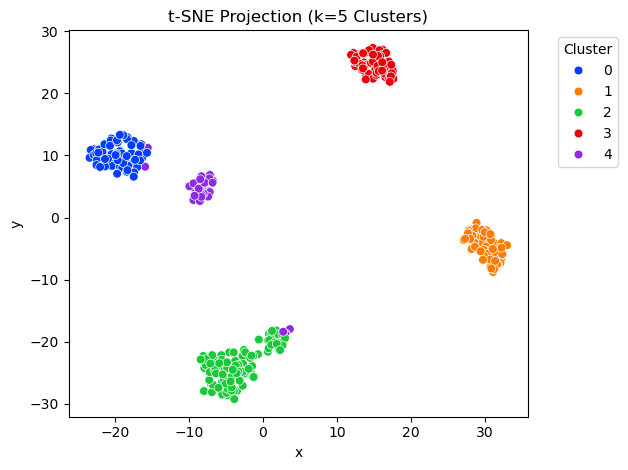

In [16]:
model = TSNE(learning_rate = 150)
transformed = model.fit_transform(samples)

# Convert to DataFrame for Seaborn
tsne_df = pd.DataFrame({
    'x': transformed[:, 0],
    'y': transformed[:, 1],
    'label': df['label']
})

# Plot with seaborn
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='bright', s=40, edgecolor='w', linewidth=0.5)
plt.title("t-SNE Projection (k=5 Clusters)")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./plots/tsne_map_5.png', format='png')
plt.show()

## Summary of Cluster Characteristics

To better understand the defining traits of each cluster, the dataset is now summarised by computing the average values of key numerical features for each cluster group. This analysis provides a clearer picture of the biological and physical differences captured by the clustering algorithm.

By examining the mean values of culmen length, culmen depth, and flipper length across clusters, we gain insight into how these groups vary in terms of physical dimensions. This summary not only supports interpretation but also highlights which features most strongly distinguish the clusters from one another.


In [17]:
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','label']
stat_penguins = df[numeric_columns].groupby('label').mean()
display(stat_penguins)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm
label,,,
0,40.315714,19.011429,192.242857
1,49.473770,15.718033,221.540984
2,39.744660,17.588350,188.864078
3,45.563793,14.237931,212.706897
4,50.965000,19.195000,199.075000


## 🐧 Plot Twist!

When plotting the `sex_MALE` column alongside the cluster labels, something unexpected shows up — in **Cluster 4**, both males *and* females appear! 🤯

This suggests a surprising overlap, possibly caused by **small males** from one species clustering together with **larger females** from another. Could it be that we overlooked the third penguin species in our earlier assumptions? ♂️🐧♀️

Curious about this anomaly, I ran the clustering again using `k = 6` (maybe the mix would disappear?) — but nope, the overlap persisted. Tried `k = 7`? Still there. It wasn’t until I reached **`k = 8`** that the clusters finally started to separate more clearly by sex — just like that subtle inflection in the elbow plot had suggested all along! 👀

So now we have to wonder — is this a hint at an **undiscovered penguin species**? Or just a fascinating case of biological variation and overlap? 🧬

Of course, we can’t rule out the possibility of a **statistical quirk**, especially given the limitations of small sample sizes. Sometimes clusters can behave unexpectedly when data is sparse or unevenly distributed.

Either way, things are getting interesting. It’s like two penguin worlds colliding! 🐧💥🐧


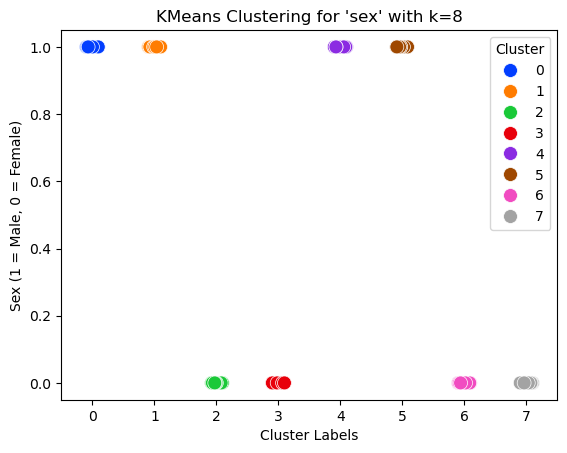

In [18]:
# Run KMeans with the optimal number of clusters
n_clusters_pt = 8
kmeans = KMeans(n_clusters=n_clusters_pt,  random_state=69)
kmeans.fit(samples)

labels = kmeans.labels_ # Get cluster labels and add it to the dataframe
df_pt = df.copy()
df_pt['label'] = labels

sns.stripplot(data=df_pt, 
              x='label', 
              y='sex_MALE', 
              hue='label', 
              palette='bright', 
              jitter=True, 
              dodge=False, 
              edgecolor='w', 
              s=10, 
              linewidth=0.5)
plt.xlabel('Cluster Labels')
plt.ylabel('Sex (1 = Male, 0 = Female)')
plt.title(f"KMeans Clustering for 'sex' with k={n_clusters_pt}")
plt.legend(title='Cluster')
plt.savefig('./plots/label_sex_k8_stripplot.png', format='png')
plt.show()

### 🧪 So... Was It Really a New Penguin Species?

After all the excitement, it’s time to put the theory to the test.

I ran a t-SNE projection using the clustering results from `k = 8`, hoping it would clearly reveal that mysterious fourth species. But... not quite. 😅

The map didn’t show a clean new cluster. Instead, some of the existing groups began to **overlap**, and what initially looked like a brand-new group turned out to be just a subtle variation within the existing clusters — probably reflecting natural differences between males and females, or just size variation within a species.

So, the dream of discovering a new penguin species? 🐧❌  
More likely, we were bumping up against the limits of the features we had available — not stumbling onto a hidden biological breakthrough.

Still, it was an awesome twist in the journey, and a great reminder of just how important **visualisation and validation** are when working with clustering! 🙌



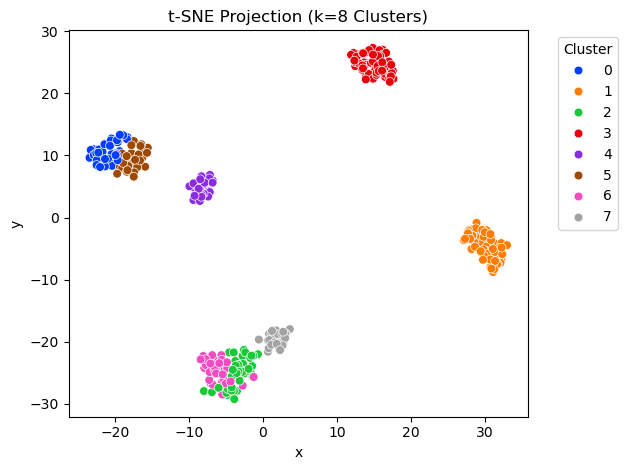

In [19]:
model = TSNE(learning_rate = 150)
transformed = model.fit_transform(samples)

# Convert to DataFrame for Seaborn
tsne_df_8 = pd.DataFrame({
    'x': transformed[:, 0],
    'y': transformed[:, 1],
    'label': df_pt['label']
})

# Plot with seaborn
sns.scatterplot(data=tsne_df_8, 
                x='x', 
                y='y', 
                hue='label', 
                palette='bright', 
                s=40, 
                edgecolor='w', 
                linewidth=0.5)
plt.title("t-SNE Projection (k=8 Clusters)")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./plots/tsne_map_8.png', format='png')
plt.show()

## 🧊 Wrapping It All Up

This project turned out to be more than just a clustering exercise — it became a journey through the quirks and complexities of biological data. From spotting clear species distinctions to chasing the idea of a fourth penguin species, it showed how powerful (and sometimes surprising!) unsupervised learning can be.

In the end, the clusters made sense, the visualisations told compelling stories, and the t-SNE maps kept things honest. And while we didn’t uncover a brand-new species, we did uncover some cool patterns — and proved that even subtle features can hold a lot of information when explored the right way.

🔍 **Key takeaways:**
- Standardising data is essential for fair comparisons.
- Visual tools like elbow plots and t-SNE are your best friends.
- Biological data has layers — and sometimes overlaps!
- Clustering is as much art as science. 🎨📊

Thanks for following along — and remember, whether it’s penguins or people, data always has a story to tell. 🐧✨
